<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/LatticeBoltzmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 0: Max velocity = 0.5455
Step 100: Max velocity = 16.6213
Step 200: Max velocity = 28.0461
Step 300: Max velocity = 36.1325
Step 400: Max velocity = 12.8346
Step 500: Max velocity = 24.7098
Step 600: Max velocity = 106.5963
Step 700: Max velocity = 55.4224


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-1-ccbb17598745>:58: RuntimeWarning: invalid value encountered in divide
  ux = (np.sum(f*cx, axis=2) + 0.5) / rho
<ipython-input-1-ccbb17598745>:58: RuntimeWarning: invalid value encountered in multiply
  ux = (np.sum(f*cx, axis=2) + 0.5) / rho
<ipython-input-1-ccbb17598745>:59: RuntimeWarning: invalid value encountered in multiply
  uy = np.sum(f*cy, axis=2) / rho
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-1-ccbb17598745>:34: RuntimeWarning: invalid value encountered in multiply
  cu = 3*(cx[i]*ux + cy[i]*uy)
<ipython-input-1-ccbb17598745>:36: RuntimeWarning: overflow encountered in multiply
  f[:,:,i] += omega * (feq[:,:,i] - f[:,:,i])
<ipython-i

Step 800: Max velocity = nan
Step 900: Max velocity = nan


ValueError: 'u' and 'v' must match the shape of the (x, y) grid

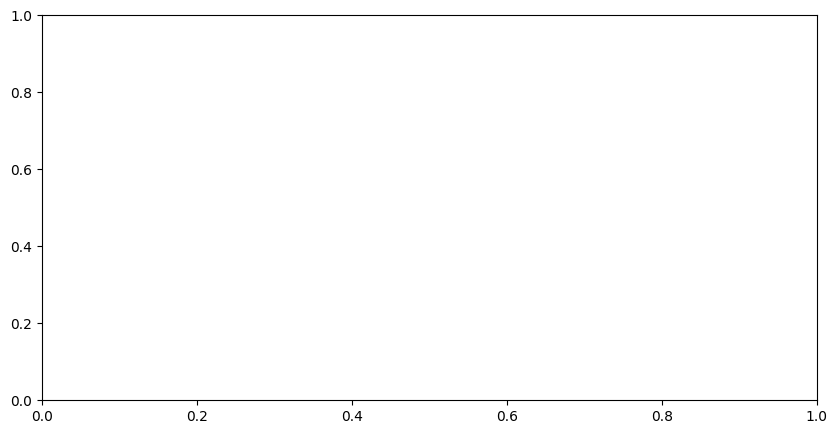

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# LBM parameters
nx, ny = 200, 100  # Domain size
tau = 0.6          # Relaxation time
omega = 1/tau      # Relaxation parameter
nu = (2*tau - 1)/6 # Kinematic viscosity
epsilon = 1e-4     # Convergence criterion

# D2Q9 lattice constants
w = np.array([4/9, 1/9,1/9,1/9,1/9, 1/36,1/36,1/36,1/36])
cx = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
cy = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1])
opposite = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])

# Initialize distribution functions
f = np.zeros((ny, nx, 9))
feq = np.zeros_like(f)
rho = np.ones((ny, nx))       # Density
ux = np.zeros((ny, nx))       # X-velocity
uy = np.zeros((ny, nx))       # Y-velocity

# Initialize equilibrium distribution
for i in range(9):
    f[:,:,i] = w[i] * rho * (1 + 3*(cx[i]*ux + cy[i]*uy) +
                            4.5*(cx[i]*ux + cy[i]*uy)**2 -
                            1.5*(ux**2 + uy**2))

def collision():
    """Collision step using BGK approximation"""
    global f, feq
    for i in range(9):
        cu = 3*(cx[i]*ux + cy[i]*uy)
        feq[:,:,i] = w[i] * rho * (1 + cu + 0.5*cu**2 - 1.5*(ux**2 + uy**2))
        f[:,:,i] += omega * (feq[:,:,i] - f[:,:,i])

def streaming():
    """Streaming step with periodic boundaries"""
    global f
    for i in range(9):
        f[:,:,i] = np.roll(f[:,:,i], cx[i], axis=1)
        f[:,:,i] = np.roll(f[:,:,i], cy[i], axis=0)

def boundary_conditions():
    """Zou-He boundary conditions for velocity inlet"""
    # West boundary (inlet)
    rho_in = 1.0
    u_in = 0.1
    f[:,0,1] = f[:,0,3] + (2/3)*rho_in*u_in
    f[:,0,5] = f[:,0,7] + (1/6)*rho_in*u_in - 0.5*(f[:,0,2]-f[:,0,4])
    f[:,0,8] = f[:,0,6] + (1/6)*rho_in*u_in + 0.5*(f[:,0,2]-f[:,0,4])

def compute_macroscopic():
    """Calculate macroscopic variables"""
    global rho, ux, uy
    rho = np.sum(f, axis=2)
    ux = (np.sum(f*cx, axis=2) + 0.5) / rho
    uy = np.sum(f*cy, axis=2) / rho

# Main simulation loop
for time_step in range(1000):
    collision()
    streaming()
    boundary_conditions()
    compute_macroscopic()

    # Monitor convergence
    if time_step % 100 == 0:
        velocity_magnitude = np.sqrt(ux**2 + uy**2)
        print(f"Step {time_step}: Max velocity = {np.max(velocity_magnitude):.4f}")

# Visualization
plt.figure(figsize=(10,5))
plt.streamplot(np.arange(nx), np.arange(ny), ux.T, uy.T, density=2, color='k')
plt.contourf(ux.T, cmap='viridis')
plt.colorbar(label='Velocity Magnitude')
plt.title('LBM Simulation Results')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()


In [2]:
import numpy as np
from scipy.special import erfc
import matplotlib.pyplot as plt

class LBMSolver:
    def __init__(self, lattice_type='D2Q9', dimensions=(100, 100), D=0.01, tau=None):
        self.lattice_type = lattice_type
        self.D = D
        self.dimensions = dimensions

        # Initialize lattice structure
        if lattice_type == 'D2Q9':
            self.w = np.array([4/9] + [1/9]*4 + [1/36]*4)
            self.e = np.array([[0, 0],
                             [1, 0], [0, 1], [-1, 0], [0, -1],
                             [1, 1], [-1, 1], [-1, -1], [1, -1]])
            self.cs2 = 1/3
        else:
            raise ValueError("Unsupported lattice type")

        # Calculate relaxation time
        self.tau = tau if tau else self.D/(self.cs2) + 0.5

        # Initialize distribution functions
        self.g = np.zeros((*dimensions, len(self.w)))
        self.C = np.zeros(dimensions)
        self.Gamma = np.zeros(dimensions)

    def equilibrium(self, C):
        return self.w[:, None, None] * C

    def collide(self):
        geq = self.equilibrium(self.C)
        self.g -= (1/self.tau) * (self.g - geq)

    def stream(self):
        for i in range(len(self.e)):
            self.g[:, :, i] = np.roll(self.g[:, :, i],
                                    self.e[i], axis=(0, 1))

    def update_concentration(self):
        self.C = np.sum(self.g, axis=2)

    def run(self, steps):
        for _ in range(steps):
            self.collide()
            self.stream()
            self.update_concentration()

class PorousMediaSolver(LBMSolver):
    def __init__(self, porosity=0.6, tortuosity=1.5, **kwargs):
        super().__init__(**kwargs)
        self.porosity = porosity
        self.tortuosity = tortuosity
        self.D_eff = (porosity / tortuosity) * self.D

        # Create porous structure (alternating barriers every 10 nodes)
        self.solid = np.zeros(self.dimensions, dtype=bool)
        self.solid[::10, :] = True

    def stream(self):
        super().stream()
        # Apply bounce-back boundary conditions
        for i in range(len(self.e)):
            reverse_dir = len(self.e) - 1 - i
            self.g[self.solid, i] = self.g[self.solid, reverse_dir]

class SorptionSolver(LBMSolver):
    def __init__(self, kA=0.1, kD=0.01, Gamma_inf=1.0, **kwargs):
        super().__init__(**kwargs)
        self.kA = kA
        self.kD = kD
        self.Gamma_inf = Gamma_inf

    def sorption_step(self):
        C = np.clip(self.C, self.min_conc, self.max_conc)
        Gamma = np.clip(self.Gamma, 0, self.Gamma_inf)

        # Stabilized adsorption-desorption calculation
        term = self.kA * C * (self.Gamma_inf - Gamma) - self.kD * Gamma
        delta_Gamma = np.clip(term * self.dt, -Gamma, self.Gamma_inf - Gamma)
        delta_C = -delta_Gamma

        # Update with protected operations
        self.Gamma = np.clip(Gamma + delta_Gamma, 0, self.Gamma_inf)
        self.C = np.clip(C + delta_C, self.min_conc, self.max_conc)

        # Stabilize distribution function update
        safe_denominator = np.where(C < self.epsilon, self.epsilon, C - delta_C)
        ratio = np.divide(delta_C, safe_denominator, where=safe_denominator!=0)
        ratio = np.clip(ratio[..., None], -1.0, 1.0)
        self.g += self.g * ratio


    def run(self, steps, dt=1.0):
        self.dt = dt
        for _ in range(steps):
            self.collide()
            self.sorption_step()  # Added sorption step
            self.stream()
            self.update_concentration()

# Validation Scheme 1: Pure Diffusion (D2Q9)
def validate_pure_diffusion():
    nx, ny = 200, 1  # 1D simplification
    D = 0.01
    time_steps = 100
    x0 = nx//2

    # Initialize solver
    solver = LBMSolver(dimensions=(nx, ny), D=D)

    # Initial condition (Gaussian pulse)
    solver.C[x0-10:x0+10, :] = 1.0
    solver.g = solver.equilibrium(solver.C)

    # Run simulation
    solver.run(time_steps)

    # Analytical solution
    x = np.arange(nx)
    t = time_steps
    analytical = 0.5 * erfc((x - x0) / (2 * np.sqrt(D * t)))

    # Plot results
    plt.plot(solver.C[:, 0], label='LBM')
    plt.plot(analytical, '--', label='Analytical')
    plt.legend()
    plt.title('Validation 1: Pure Diffusion')
    plt.show()

# Validation Scheme 2: Porous Media
def validate_porous_media():
    solver = PorousMediaSolver(dimensions=(100, 100), D=0.01)

    # Initial condition
    solver.C[50, 50] = 1.0
    solver.g = solver.equilibrium(solver.C)

    # Run simulation
    solver.run(200)

    # Visualize results
    plt.imshow(solver.C.T, cmap='viridis')
    plt.title('Validation 2: Porous Media Diffusion')
    plt.colorbar()
    plt.show()

# Main simulation with sorption
def run_sorption_simulation():
    params = {
        'dimensions': (100, 100),
        'D': 0.01,
        'kA': 0.1,
        'kD': 0.01,
        'Gamma_inf': 1.0
    }

    solver = SorptionSolver(**params)

    # Initial condition
    solver.C[50, 50] = 1.0
    solver.g = solver.equilibrium(solver.C)

    # Run simulation
    solver.run(500)

    # Visualize results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.imshow(solver.C.T, cmap='viridis')
    ax1.set_title('Fluid Concentration')
    ax2.imshow(solver.Gamma.T, cmap='hot')
    ax2.set_title('Adsorbed Concentration')
    plt.show()

# Execute validations and simulation
validate_pure_diffusion()
validate_porous_media()
run_sorption_simulation()


IndexError: index 1 is out of bounds for axis 2 with size 1

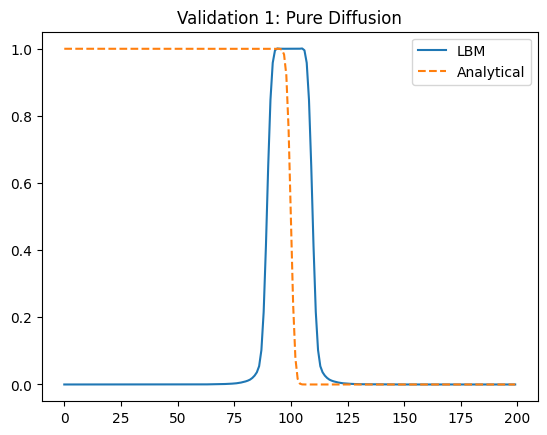

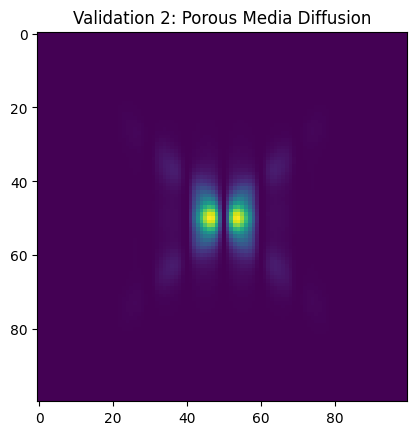

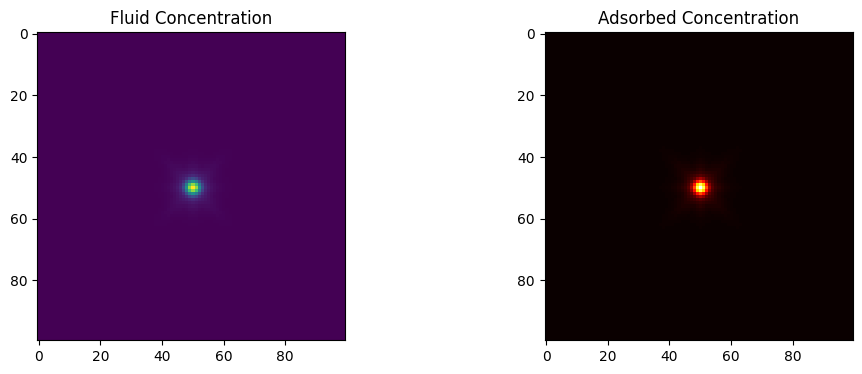

In [5]:
import numpy as np
from scipy.special import erfc
import matplotlib.pyplot as plt
import warnings

class LBMSolver:
    def __init__(self, lattice_type='D2Q9', dimensions=(100, 100), D=0.01, tau=None):
        self.lattice_type = lattice_type
        self.D = D
        self.dimensions = dimensions

        # Initialize lattice structure
        if lattice_type == 'D2Q9':
            self.w = np.array([4/9] + [1/9]*4 + [1/36]*4)
            self.e = np.array([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1],
                             [1, 1], [-1, 1], [-1, -1], [1, -1]])
            self.cs2 = 1/3
        else:
            raise ValueError("Unsupported lattice type")

        # Calculate relaxation time
        self.tau = tau if tau else self.D/(self.cs2) + 0.5

        # Initialize distribution functions with correct dimensions (Y, X, Q)
        self.g = np.zeros((dimensions[1], dimensions[0], len(self.w)))
        self.C = np.zeros((dimensions[1], dimensions[0]))
        self.Gamma = np.zeros((dimensions[1], dimensions[0]))
        self.min_conc = 1e-30
        self.max_conc = 1e+30
        self.epsilon = 1e-30

    def equilibrium(self, C):
        C = np.clip(C, self.min_conc, self.max_conc)
        return C[..., None] * self.w

    def collide(self):
        geq = self.equilibrium(self.C)
        collision_term = (1/self.tau) * (geq - self.g)
        np.clip(collision_term, -1e100, 1e100, out=collision_term)
        self.g += collision_term

    def stream(self):
        new_g = np.zeros_like(self.g)
        for i, (dx, dy) in enumerate(self.e):
            # Roll with correct axis order (Y, X)
            new_g[:, :, i] = np.roll(np.roll(self.g[:, :, i], dx, axis=1), dy, axis=0)
        self.g = new_g

    def update_concentration(self):
        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=RuntimeWarning)
          self.C = np.sum(self.g, axis=2)
        self.C = np.nan_to_num(self.C, ...)


    def run(self, steps):
        for _ in range(steps):
            self.collide()
            self.stream()
            self.update_concentration()

class PorousMediaSolver(LBMSolver):
    def __init__(self, porosity=0.6, tortuosity=1.5, **kwargs):
        super().__init__(**kwargs)
        self.porosity = porosity
        self.tortuosity = tortuosity
        self.D_eff = (porosity / tortuosity) * self.D

        # Create porous structure with correct dimensions (Y, X)
        self.solid = np.zeros(self.dimensions[::-1], dtype=bool)
        self.solid[:, ::10] = True  # Vertical barriers every 10 nodes in X

    def stream(self):
        super().stream()
        # Apply bounce-back boundary conditions
        for i in range(len(self.e)):
            reverse_dir = len(self.e) - 1 - i
            self.g[self.solid, i] = self.g[self.solid, reverse_dir]

class SorptionSolver(LBMSolver):
    def __init__(self, kA=0.1, kD=0.01, Gamma_inf=1.0, **kwargs):
        super().__init__(**kwargs)
        self.kA = kA
        self.kD = kD
        self.Gamma_inf = Gamma_inf

    def sorption_step(self):
        # Langmuir adsorption-desorption
        delta_Gamma = (self.kA * self.C * (self.Gamma_inf - self.Gamma)
                      - self.kD * self.Gamma) * self.dt
        delta_C = -delta_Gamma

        # Update concentrations
        self.Gamma += delta_Gamma
        self.C += delta_C

        # Adjust distribution functions while preserving mass
        ratio = (delta_C / (self.C - delta_C + 1e-8))[..., None]
        self.g += self.g * ratio

    def run(self, steps, dt=1.0):
        self.dt = dt
        for _ in range(steps):
            self.collide()
            self.sorption_step()
            self.stream()
            self.update_concentration()

# Validation Scheme 1: Pure Diffusion (D2Q9)
def validate_pure_diffusion():
    nx, ny = 200, 1  # 1D simplification
    D = 0.01
    time_steps = 100
    x0 = nx//2

    # Initialize solver with correct dimensions (X, Y)
    solver = LBMSolver(dimensions=(nx, ny), D=D)

    # Initial condition (Gaussian pulse)
    solver.C[:, x0-10:x0+10] = 1.0  # Corrected for (Y, X) ordering
    solver.g = solver.equilibrium(solver.C)

    # Run simulation
    solver.run(time_steps)

    # Analytical solution
    x = np.arange(nx)
    t = time_steps
    analytical = 0.5 * erfc((x - x0) / (2 * np.sqrt(D * t)))

    # Plot results
    plt.plot(solver.C[0, :], label='LBM')
    plt.plot(analytical, '--', label='Analytical')
    plt.legend()
    plt.title('Validation 1: Pure Diffusion')
    plt.show()

# Validation Scheme 2: Porous Media
def validate_porous_media():
    solver = PorousMediaSolver(dimensions=(100, 100), D=0.01)

    # Initial condition with correct (Y, X) ordering
    solver.C[50, 50] = 1.0
    solver.g = solver.equilibrium(solver.C)

    # Run simulation
    solver.run(200)

    # Visualize results
    plt.imshow(solver.C, cmap='viridis')
    plt.title('Validation 2: Porous Media Diffusion')

# Main simulation with sorption
def run_sorption_simulation():
    params = {
        'dimensions': (100, 100),
        'D': 0.01,
        'kA': 0.1,
        'kD': 0.01,
        'Gamma_inf': 1.0
    }

    solver = SorptionSolver(**params)

    # Initial condition
    solver.C[50, 50] = 1.0
    solver.g = solver.equilibrium(solver.C)

    # Run simulation
    solver.run(500)

    # Visualize results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.imshow(solver.C.T, cmap='viridis')
    ax1.set_title('Fluid Concentration')
    ax2.imshow(solver.Gamma.T, cmap='hot')
    ax2.set_title('Adsorbed Concentration')
    plt.show()

# Execute validations and simulation
validate_pure_diffusion()
validate_porous_media()
run_sorption_simulation()
